In [27]:
%load_ext autoreload
%autoreload 2

from collect_experiments import display_experiments

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Pretrained SPECTRAL (N=50) {'ddg': 0.64074637, 'ddg_std': 1.1962057257583896, 'pos_ddg_prop': 0.6731770833333334, 'll': -128.5896453857422, 'll_std': 42.161268092521254}
DRAKES {'ddg': 1.0762512499999999, 'ddg_std': 0.8210351286830646, 'pos_ddg_prop': 0.8587239583333334, 'scrmsd': 0.8988032639026642, 'scrmsd_std': 1.202034489322876, 'low_scrmsd_prop': 0.9342447916666666, 'success_rate': 0.7975260416666666, 'll': -144.11238861083984, 'll_std': 41.5608073079779}
Pretrained BON (N=50) {'ddg': 0.72784373, 'ddg_std': 1.196098048920687, 'pos_ddg_prop': 0.68359375, 'll': -128.2330551147461, 'll_std': 41.96095466680893}
Pretrained BEAM (N=50) {'ddg': 1.1720432, 'ddg_std': 1.1948892719455697, 'pos_ddg_prop': 0.8098958333333334, 'll': -133.0861053466797, 'll_std': 41.75854839055888}
Pretrained LASSO (N=50, λ=0.0005) {'ddg': 0.38709155, 'ddg_std': 1.236570165690221, 'pos_ddg_prop': 0.5989583333333334, 'll': -128.33741760253906, 'll_std': 42.58177579324062}
Pretrained {'ddg': -0.551643185, 'ddg_st

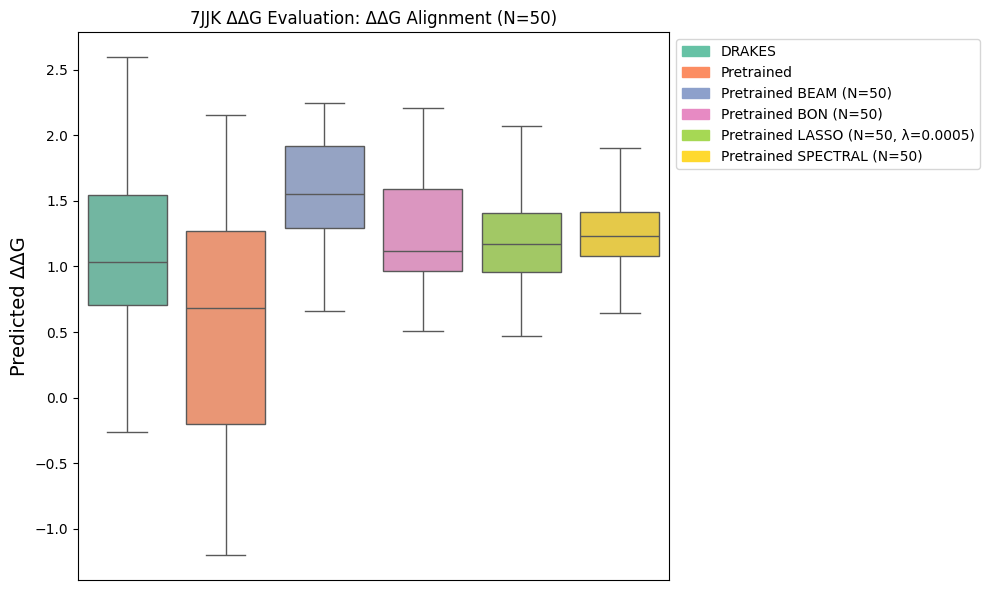

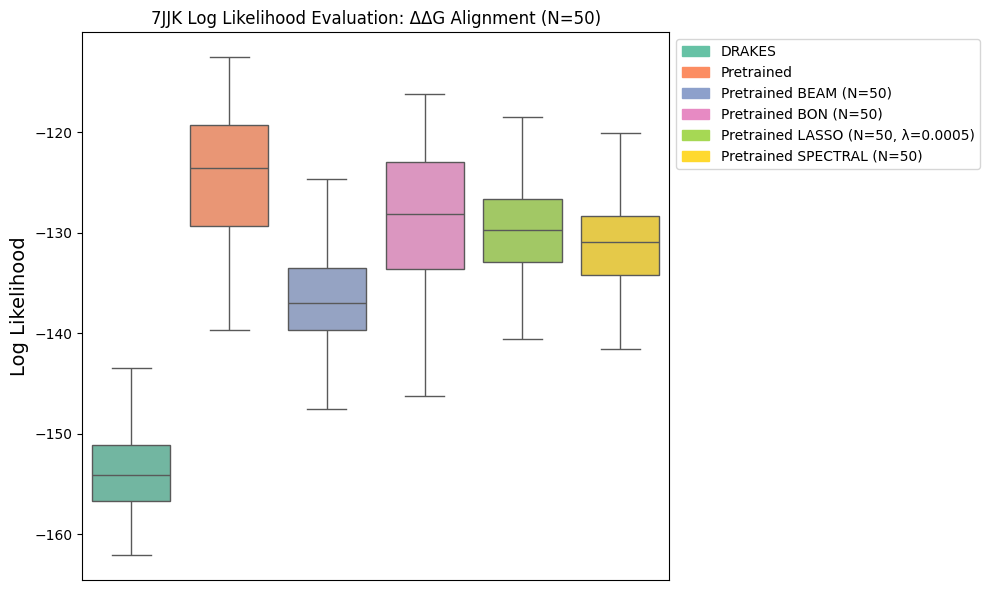

In [28]:
display_experiments(50, 'ddg', dataset='test', target_protein='7JJK')